# Install Dependencies

In [1]:
!pip install torch_snippets torchsummary pycocotools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 580.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.6/106.6 kB 1.2 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / - \ | / - done
  Getting requirements to build wheel ... - \ | / done
  Preparing metadata (pyproject.toml) ... - \ | / done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for pycocotools: filename=pycocotools-2.0.4-cp37-cp37m-linux_x86_64.whl size=370077 sha256=942049d0da2b4dc8be0f76a0b1a3d1b4a2cd026d68f758c2de5dabfea112b311
  Stored in directory: /root/.cache/pip/wheels/a3/5f/fa/f011e578cc76e1fc5be8dce30b3eb9fd00f337e744b3bba59b
  Created wheel for typing: filename=typing-3.7.4.3-py3-none-any.whl size=26325 sha256=218afbf658da0e9be8058747d6e099ee68c5c3280b8fc0abd7d9958efd5ac6e3

# Import Libraries

In [2]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import glob 
import random 

import torch
from torchvision import transforms as T
from torch_snippets import *

# Process Dataset

In [3]:
data = pd.read_csv('../input/car-object-detection/data/train_solution_bounding_boxes (1).csv')
data[['xmin', 'ymin', 'xmax', 'ymax']] = data[['xmin', 'ymin', 'xmax', 'ymax']].astype(int)
data.head()

,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281,187,327,223
1,vid_4_10000.jpg,15,187,120,236
2,vid_4_10040.jpg,239,176,361,236
3,vid_4_10020.jpg,496,172,630,231
4,vid_4_10060.jpg,16,186,132,238


Image Shape: (380, 676, 3)


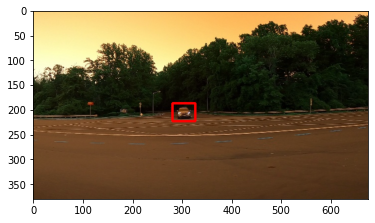

In [4]:
DIR = '../input/car-object-detection/data/training_images/'
row = dict(data.iloc[0])
img = cv2.imread(DIR + row['image'])
print('Image Shape:', img.shape)
xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']
cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255, 0, 0), 3)
plt.imshow(img)

## Convert CSV to COCO
> Reference: [How to Convert Tensorflow Object Detection CSV data to CoCo Json Format](https://medium.com/analytics-vidhya/how-to-convert-tensorflow-object-detection-csv-data-to-coco-json-format-d0693d5b2f75)

In [5]:
def image(row):
    image = {}
    img = cv2.imread(DIR + row.image)
    image["height"] = img.shape[0]
    image["width"] = img.shape[1]
    image["id"] = row.fileid
    image["file_name"] = row.image
    return image

def annotation(row):
    annotation = {}
    area = (row.xmax -row.xmin)*(row.ymax - row.ymin)
    annotation["segmentation"] = []
    annotation["iscrowd"] = 0
    annotation["area"] = area
    annotation["image_id"] = row.fileid
    annotation["bbox"] = [row.xmin, row.ymin, row.xmax-row.xmin, row.ymax-row.ymin]
    annotation["category_id"] = row.categoryid
    annotation["id"] = row.annid
    return annotation

In [6]:
train_json_path = 'train_coco.json'
val_json_path = 'val_coco.json'

categories = []
train_images = []
train_annotations = []
val_images = []
val_annotations = []

In [7]:
# dataset only has a single category, car
category = {}
category["supercategory"] = 'none'
category["id"] = 1
category["name"] = 'car'
categories.append(category)

In [8]:
data['fileid'] = data['image'].astype('category').cat.codes
data['categoryid']= 1
data['annid'] = data.index
data.head()

,image,xmin,ymin,xmax,ymax,fileid,categoryid,annid
0,vid_4_1000.jpg,281,187,327,223,0,1,0
1,vid_4_10000.jpg,15,187,120,236,1,1,1
2,vid_4_10040.jpg,239,176,361,236,3,1,2
3,vid_4_10020.jpg,496,172,630,231,2,1,3
4,vid_4_10060.jpg,16,186,132,238,4,1,4


In [9]:
train_val_imgs = glob.glob('../input/car-object-detection/data/training_images/*')
train_val_imgs = list(map(fname, train_val_imgs))
random.shuffle(train_val_imgs)
val_imgs = train_val_imgs[:50]
train_imgs = train_val_imgs[50:]
print('Training Size:', len(train_imgs))
print('Validation Size:', len(val_imgs))

Training Size: 951
Validation Size: 50


In [10]:
for row in data.itertuples():
    if row.image in val_imgs:
        val_annotations.append(annotation(row))
    else:
        train_annotations.append(annotation(row))

imagedf = data.drop_duplicates(subset=['fileid']).sort_values(by='fileid')
for row in imagedf.itertuples():
    if row.image in val_imgs:
        val_images.append(image(row))
    else:
        train_images.append(image(row))

train_data_coco = {}
train_data_coco["images"] = train_images
train_data_coco["categories"] = categories
train_data_coco["annotations"] = train_annotations
json.dump(train_data_coco, open(train_json_path, "w"), indent=4)

val_data_coco = {}
val_data_coco["images"] = val_images
val_data_coco["categories"] = categories
val_data_coco["annotations"] = val_annotations
json.dump(val_data_coco, open(val_json_path, "w"), indent=4)

# DETR (DEtection TRansformer)
<img src="https://production-media.paperswithcode.com/methods/Screen_Shot_2020-07-20_at_9.17.39_PM_ZHS2kmV.png" alt="DETR" width="800">   

Reference: [DE⫶TR: End-to-End Object Detection with Transformers](https://github.com/facebookresearch/detr)  

In [11]:
# 
if not os.path.exists('detr'):
    !git clone https://github.com/sizhky/detr/

Cloning into 'detr'...
remote: Enumerating objects: 283, done.
remote: Total 283 (delta 0), reused 0 (delta 0), pack-reused 283
Receiving objects: 100% (283/283), 12.85 MiB | 17.14 MiB/s, done.
Resolving deltas: 100% (155/155), done.


In [12]:
# move files to desired folder structure
%cd detr
!mkdir annotations
!mv ../train_coco.json ./annotations/instances_train2017.json
!mv ../val_coco.json ./annotations/instances_val2017.json
!ln -s ../../input/car-object-detection/data/training_images/ train2017
!ln -s ../../input/car-object-detection/data/training_images/ val2017

/kaggle/working/detr


In [13]:
# loading pre-trained weights
if not os.path.exists('detr-r50-e632da11.pth'):
    !wget https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth
    checkpoint = torch.load("detr-r50-e632da11.pth", map_location='cpu')
    del checkpoint["model"]["class_embed.weight"]
    del checkpoint["model"]["class_embed.bias"]
    torch.save(checkpoint,"detr-r50_no-class-head.pth")

--2022-06-28 09:18:23--  https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 172.67.9.4, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 166618694 (159M) [application/octet-stream]
Saving to: ‘detr-r50-e632da11.pth’

detr-r50-e632da11.p 100%[===================>] 158.90M  33.0MB/s    in 5.6s    

2022-06-28 09:18:29 (28.4 MB/s) - ‘detr-r50-e632da11.pth’ saved [166618694/166618694]



In [14]:
!python main.py --coco_path . --nclasses=1\
  --epochs 20 --lr=1e-4 --batch_size=6 --num_workers=1\
  --output_dir="outputs" --resume="detr-r50_no-class-head.pth"

Not using distributed mode
git:
  sha: 80281780ef5f1316378a5d760e78db20a72101c1, status: clean, branch: master

Namespace(aux_loss=True, backbone='resnet50', batch_size=6, bbox_loss_coef=5, clip_max_norm=0.1, coco_panoptic_path=None, coco_path='.', dataset_file='coco', dec_layers=6, device='cuda', dice_loss_coef=1, dilation=False, dim_feedforward=2048, dist_url='env://', distributed=False, dropout=0.1, enc_layers=6, eos_coef=0.1, epochs=20, eval=False, frozen_weights=None, giou_loss_coef=2, hidden_dim=256, lr=0.0001, lr_backbone=1e-05, lr_drop=200, mask_loss_coef=1, masks=False, nclasses=1, nheads=8, num_queries=100, num_workers=1, output_dir='outputs', position_embedding='sine', pre_norm=False, remove_difficult=False, resume='detr-r50_no-class-head.pth', seed=42, set_cost_bbox=5, set_cost_class=1, set_cost_giou=2, start_epoch=0, weight_decay=0.0001, world_size=1)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-067

In [15]:
from main import get_args_parser, argparse, build_model
parser = argparse.ArgumentParser('DETR training and evaluation script', parents=[get_args_parser()])
args, _ = parser.parse_known_args()
args.nclasses = 1
model, _, _ = build_model(args)
model.load_state_dict(torch.load("outputs/checkpoint.pth")['model']);

In [16]:
COLORS = [[0.000, 0.447, 0.741], 
          [0.850, 0.325, 0.098], 
          [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], 
          [0.466, 0.674, 0.188], 
          [0.301, 0.745, 0.933]]
          
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [17]:
def process_bbox(bbox):
    x_c, y_c, w, h = bbox.unbind(1)
    new_bbox = [(x_c - 0.5 * w), (y_c - 0.5 * h),
                (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(new_bbox, dim=1)

def rescale_bboxes(bbox, size):
    img_w, img_h = size
    new_bbox = process_bbox(bbox)
    new_bbox *= torch.tensor([img_w, img_h, img_w, img_h],
                              dtype=torch.float32)
    return new_bbox
    
def detect(im, model, transform, thres=0.7):
    img = transform(im).unsqueeze(0)
    outputs = model(img)
    probs = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probs.max(-1).values > thres
    # convert boxes from [0, 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], 
                                   im.size)
    return probs[keep], bboxes_scaled

def plot_results(path_img, prob, boxes, figsize=(16, 10)):
    plt.figure(figsize=figsize)
    img = cv2.imread(path_img)
    img = cv2.resize(img, (800, 800))
    font = cv2.FONT_HERSHEY_PLAIN
    for prob, (xmin, ymin, xmax, ymax), col in \
        zip(prob, boxes.tolist(), COLORS * 100):
        xmin, ymin, xmax, ymax = int(xmin), int(ymin), int(xmax), int(ymax)
        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255, 0, 0), 3)
        cl = prob.argmax()
        text = f'car: {prob[cl]:0.2f}'
        cv2.putText(img, text, (xmin, ymin-20), font, 2, 
                    (0, 255, 0), 2)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

/kaggle/working/detr/models/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)


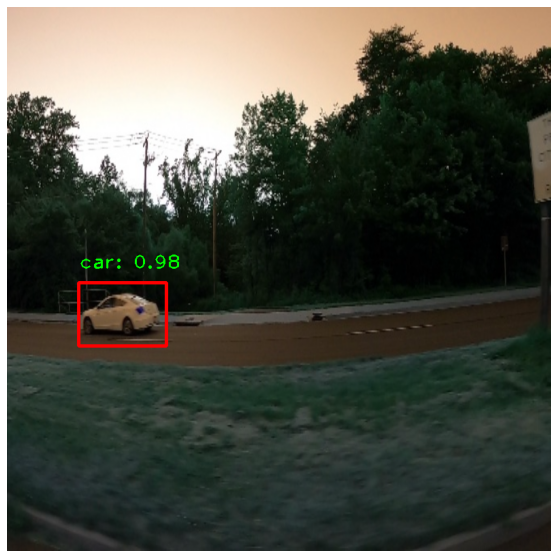

Duration (seconds): 2.79343


In [18]:
import time

start_time = time.time()
img_path = '../../input/car-object-detection/data/testing_images/vid_5_26840.jpg'
img = Image.open(img_path)
img = img.resize((800,800)).convert('RGB')
scores, boxes = detect(img, model, transform)
plot_results(img_path, scores, boxes)
print(f'Duration (seconds): {time.time() - start_time:.5f}')